In [ ]:
#IMPORTANDO BIBLIOTECAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#IMPORTANDO DADOS E ESTRUTURANDO O DATAFRAME
df_alti = pd.read_excel('diferenca_altimetria_clean.xlsx')
col_list = df_alti.columns.tolist()
trats = col_list[2:]
const = 0.138
for trat in trats:
    df_alti[trat + '_diff'] = df_alti[trat] - df_alti['NIV']+const

In [10]:
#DATAFRAME DAS DIFERENÇAS
df_diff = df_alti[df_alti.columns[5:]]
df_diff.head()
df_diff.describe()
diff_trats = df_diff.columns.tolist()

#DATAFRAME DAS DIFERENÇAS ABSOLUTAS
df_diff_abs = df_diff.abs()
df_diff_abs.head()
df_diff_abs.describe()

#SALVANDO A ESTATISTICA DESCRITIVA EM UMA TABELA
with pd.ExcelWriter('estatistica_descritiva_diferencas.xlsx') as writer:
    df_diff.describe().to_excel(writer, sheet_name='Diferencas')
    df_diff_abs.describe().to_excel(writer, sheet_name='Diferencas_Absolutas')

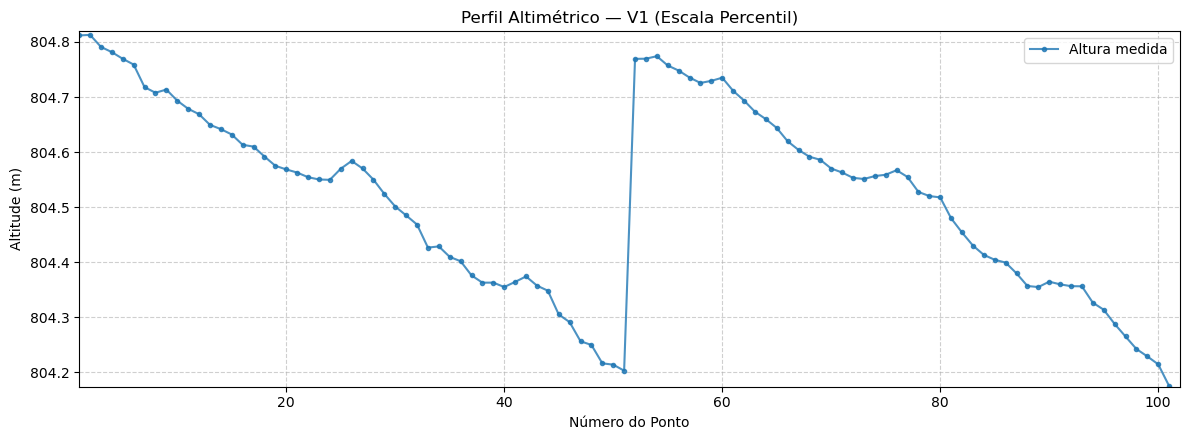

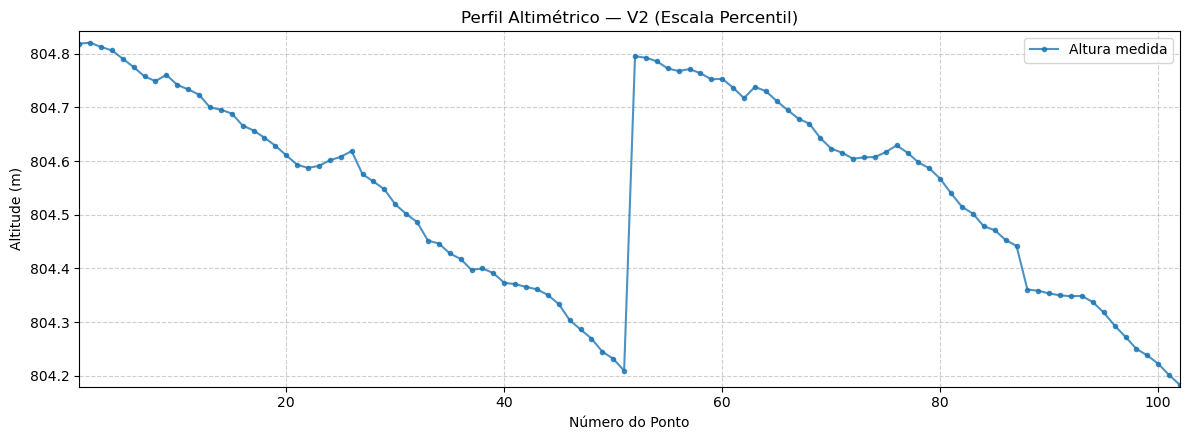

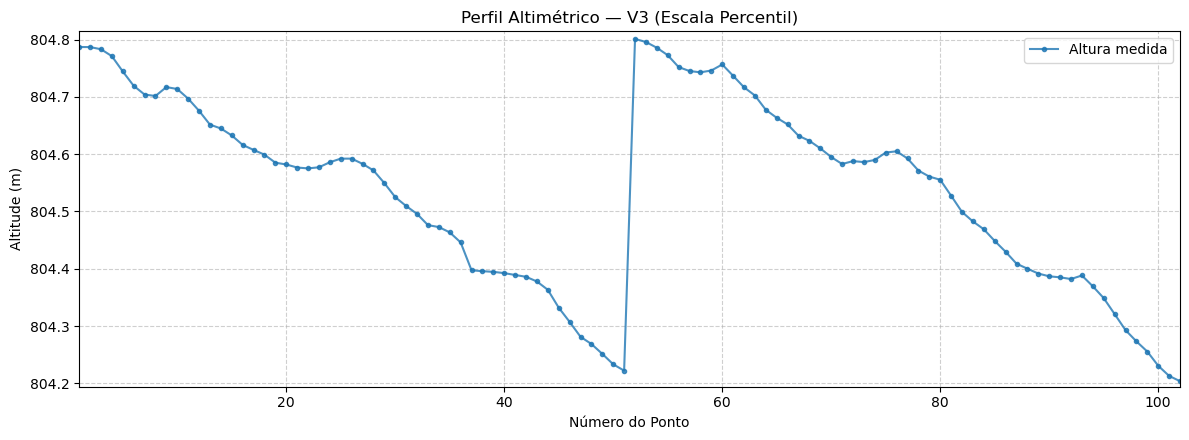

In [16]:
# -*- coding: utf-8 -*-
# PERFIL ALTIMÉTRICO — Pedro Lobato
# Gera gráficos de perfis de terreno com escala automática

# ===========================================================
# 1. IMPORTA OS DADOS ORIGINAIS
# ===========================================================
df_alti = pd.read_excel('diferenca_altimetria_clean.xlsx')

col_list = df_alti.columns.tolist()
trats = col_list[2:]   # Colunas com as alturas brutas (sem ser coordenadas ou ID)

# ===========================================================
# 2. FUNÇÕES DE ESCALA AUTOMÁTICA
# ===========================================================
def escala_percentil(z, p_low=2, p_high=98, margin_frac=0.05):
    """Define limites verticais com base nos percentis e uma margem relativa."""
    y_low = np.percentile(z, p_low)
    y_high = np.percentile(z, p_high)
    y_range = y_high - y_low if (y_high - y_low) != 0 else 1.0
    ymin = y_low - margin_frac * y_range
    ymax = y_high + margin_frac * y_range
    return ymin, ymax


def escala_polinomial(x, z, deg=2, k_std=3):
    """Define limites verticais com base em ajuste polinomial + desvio padrão."""
    coeffs = np.polyfit(x, z, deg)
    z_fit = np.polyval(coeffs, x)
    resid = z - z_fit
    sigma = np.std(resid)
    ymin = np.min(z_fit) - k_std * sigma
    ymax = np.max(z_fit) + k_std * sigma
    if (ymax - ymin) < 0.05:  # evita escala zero
        mid = np.mean(z)
        ymin, ymax = mid - 0.025, mid + 0.025
    return ymin, ymax, z_fit


# ===========================================================
# 3. FUNÇÃO DE PLOTAGEM DO PERFIL
# ===========================================================
def plot_perfil(z, metodo='percentil', nome='Perfil', save=False):
    """Gera o gráfico de perfil altimétrico com escala automática."""
    x = np.arange(1, len(z) + 1)
    z = np.asarray(z)

    if metodo == 'percentil':
        ymin, ymax = escala_percentil(z)
        z_fit = None
        titulo = f"Perfil Altimétrico — {nome} (Escala Percentil)"
    elif metodo == 'polinomial':
        ymin, ymax, z_fit = escala_polinomial(x, z)
        titulo = f"Perfil Altimétrico — {nome} (Ajuste Polinomial)"
    else:
        raise ValueError("Método inválido: use 'percentil' ou 'polinomial'")

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(12, 4.5))
    ax.plot(x, z, linestyle='-', marker='o', markersize=3, color='C0',
            label='Altura medida', alpha=0.8)

    if z_fit is not None:
        ax.plot(x, z_fit, linestyle='--', linewidth=2, color='orange',
                label='Tendência polinomial')

    ax.set_xlim(1, len(z))
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Número do Ponto')
    ax.set_ylabel('Altitude (m)')
    ax.set_title(titulo)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='best')
    plt.tight_layout()

    if save:
        nome_arquivo = f"perfil_{nome.replace(' ', '_')}_{metodo}.png"
        plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')

    plt.show()


# ===========================================================
# 4. EXECUÇÃO — GERA UM GRÁFICO PARA CADA TRATAMENTO
# ===========================================================
for trat in trats:
    plot_perfil(df_alti[trat], metodo='percentil', nome=trat, save=True)

# Se quiser usar o modelo polinomial:
# for trat in trats:
#     plot_perfil(df_alti[trat], metodo='polinomial', nome=trat, save=True)


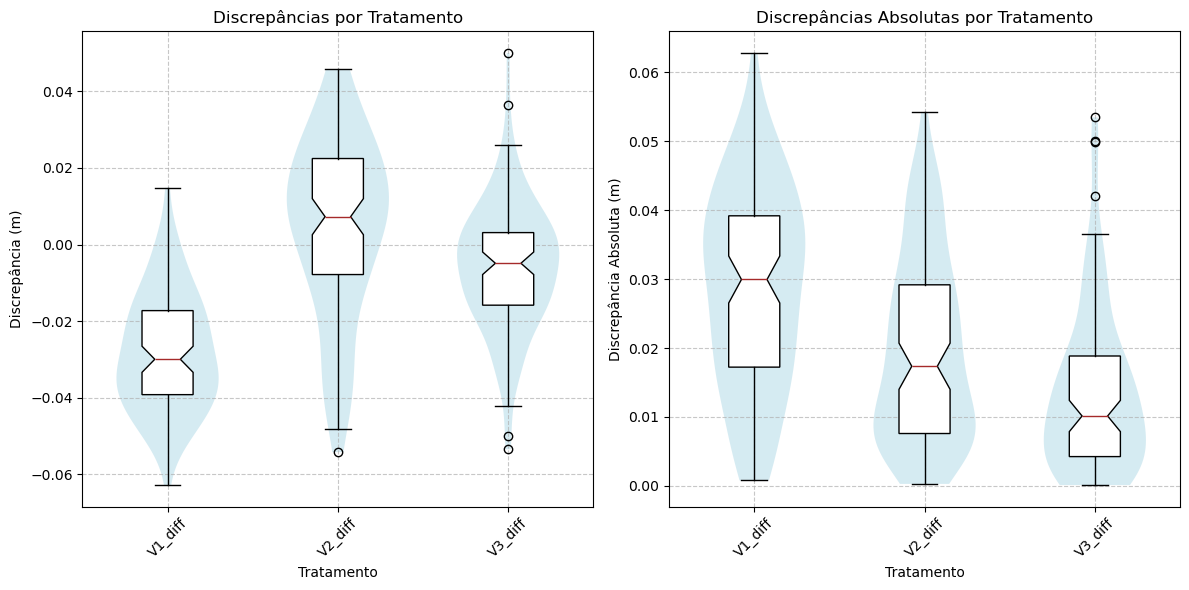

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

# GRAFICO DE BOXPLOT

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# DISCREPANCIAS
data_diff = [df_diff[col] for col in df_diff.columns]
positions_diff = np.arange(1, len(df_diff.columns) + 1)

# VIOLINGRAPH
parts1 = ax1.violinplot(data_diff, positions=positions_diff, widths=0.6,
                        showmeans=False, showmedians=False, showextrema=False)
for pc in parts1['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.5)
    pc.set_edgecolor('none')

# BOXPLOT
ax1.boxplot(data_diff, positions=positions_diff,
            notch=True, patch_artist=True,
            boxprops=dict(facecolor='white', color='black'),
            medianprops=dict(color='brown'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

ax1.set_title('Discrepâncias por Tratamento')
ax1.set_ylabel('Discrepância (m)')
ax1.set_xlabel('Tratamento')
ax1.set_xticks(positions_diff)
ax1.set_xticklabels(df_diff.columns, rotation=45)
ax1.grid(True, linestyle='--', alpha=0.7)

# DISCREPANCIAS ABSOLUTAS
data_diff_abs = [df_diff_abs[col] for col in df_diff_abs.columns]
positions_abs = list(range(1, len(df_diff.columns) + 1))

parts2 = ax2.violinplot(data_diff_abs, positions=positions_abs, widths=0.6,
                        showmeans=False, showmedians=False, showextrema=False)
for pc in parts2['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.5)
    pc.set_edgecolor('none')

ax2.boxplot(data_diff_abs, positions=positions_abs,
            notch=True, patch_artist=True,
            boxprops=dict(facecolor='white', color='black'),
            medianprops=dict(color='brown'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

ax2.set_title('Discrepâncias Absolutas por Tratamento')
ax2.set_ylabel('Discrepância Absoluta (m)')
ax2.set_xlabel('Tratamento')
ax2.set_xticks(positions_abs)
ax2.set_xticklabels(df_diff_abs.columns, rotation=45)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

plt.savefig('boxplot_com_fundo_violin.png', dpi=300, bbox_inches='tight')


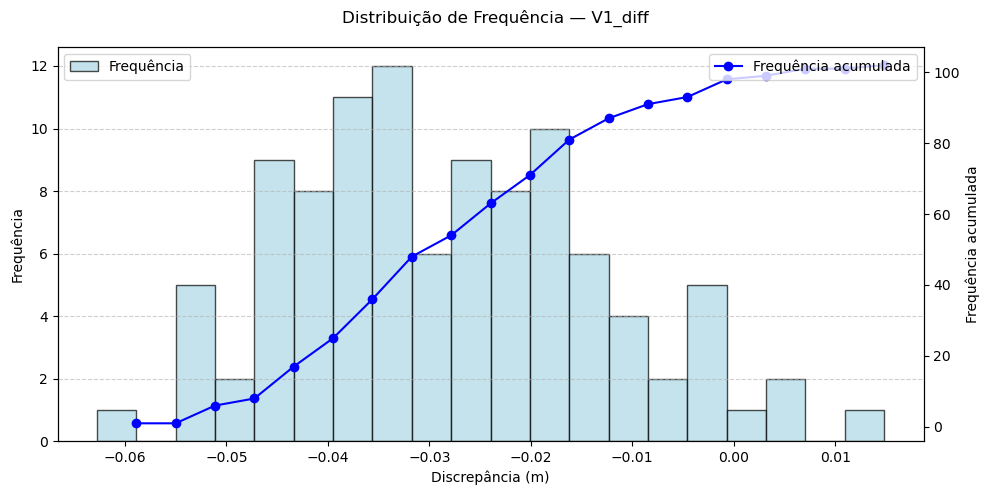

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Escolha uma coluna de df_diff ou df_diff_abs
col = 'V1_diff'  # exemplo, troque pelo nome correto
dados = df_diff[col].dropna()

# Número de bins
bins = 20

fig, ax1 = plt.subplots(figsize=(10,5))

# --- Histograma de frequência ---
n, bin_edges, patches = ax1.hist(dados, bins=bins, color='lightblue', edgecolor='black', alpha=0.7, label='Frequência')
ax1.set_xlabel('Discrepância (m)')
ax1.set_ylabel('Frequência')
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# --- Frequência acumulada ---
ax2 = ax1.twinx()  # eixo Y secundário
frequencia_acum = np.cumsum(n)
ax2.plot(bin_edges[1:], frequencia_acum, color='blue', marker='o', label='Frequência acumulada')
ax2.set_ylabel('Frequência acumulada')

# Título e legendas
fig.suptitle(f'Distribuição de Frequência — {col}')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
